In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd
import sklearn.preprocessing, sklearn.decomposition
import seaborn as sns
import umap

In [2]:
x = pd.read_csv("original_data/Stage_5.Seurat.csv", index_col = 0)
metadata = pd.read_csv('original_data/cell_metadata.csv')
x.head()

,SST,PYY,GCG,TTR,PPY,TAC1,GC,INS,NTS,CCK,...,LANCL3,FAM193A,FMN1,TPM1,VWA8,ERMAP,PTGS1,HEYL,C9orf43,ANKRD20A4
stg5diff1_S5d0_b1.bcEKBI,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.716086,0.0,...,0.0,0.420816,0.0,1.829704,0.000000,0.0,0.0,0.0,0.0,0.0
stg5diff1_S5d0_b1.bcDAND,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,1.866169,0.000000,0.0,0.0,0.0,0.0,0.0
stg5diff1_S5d0_b1.bcGQEK,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,1.007309,0.0,2.073536,0.000000,0.0,0.0,0.0,0.0,0.0
stg5diff1_S5d0_b1.bcFOEC,0.000000,0.0,0.0,1.175463,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,1.700974,0.000000,0.0,0.0,0.0,0.0,0.0
stg5diff1_S5d0_b1.bcAVAX,1.272205,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,1.272205,0.0,0.000000,1.272205,0.0,0.0,0.0,0.0,0.0


In [3]:
x.shape

(51274, 2500)

### Standardized such that each gene has zero mean and unit variance over all cells

In [3]:
scaler = sklearn.preprocessing.StandardScaler()
normalized_x = pd.DataFrame(scaler.fit_transform(x), index = x.index, columns = x.columns)

Identify genes correlated with TOP2A

In [4]:
import scipy.stats

x1 = normalized_x['TOP2A']
rs = {}
for g in normalized_x.columns: 
    
    x2 = normalized_x[g]
    r, pval = scipy.stats.pearsonr(x1, x2)

    rs[g] = r
rs = pd.Series(rs)
(rs > 0.15).value_counts()

False    2400
True      100
dtype: int64

### PCA to 30 dim 

Use only genes that are not correlated with TOP2A as input into PCA

In [5]:
pca = sklearn.decomposition.PCA(n_components = 30, random_state=0)
um = umap.UMAP(n_components = 2, metric = 'euclidean', n_neighbors = 30, random_state=42,transform_seed=42)

normalized_x_f = normalized_x.loc[:,rs < 0.15]
X_pca = pca.fit_transform(normalized_x_f)

xp = pd.DataFrame(X_pca, index = normalized_x.index)
xu = um.fit_transform(xp)

### All Data seperate by Time points

In [6]:
y = metadata['CellWeek'].values.astype(int)
x_l = [normalized_x_f.loc[y == d,].values for d in [0,1,2,3,4,5,6,7]]
xp_l = [xp.loc[y == d,].values for d in [0,1,2,3,4,5,6,7]]
xu_l = [xu[y == d,] for d in [0,1,2,3,4,5,6,7]]

x_l = [torch.from_numpy(a).float() for a in x_l]
xp_l = [torch.from_numpy(a).float() for a in xp_l]
xu_l = [torch.from_numpy(a).float() for a in xu_l]

In [7]:
celltype_ = [metadata['Assigned_cluster'][(y == d)]  for d in [0,1,2,3,4,5,6,7]]
genes = normalized_x_f.columns

In [8]:
unique_cell_types = metadata['Assigned_cluster'].unique()
default_colors = sns.color_palette("tab20", len(unique_cell_types))
color_palette_dict = {cell_type: color for cell_type, color in zip(unique_cell_types, default_colors)}

In [9]:
torch.save({
    'x': x_l, 
    'xp': xp_l, 
    'xu': xu_l, 
    'y': [0,1,2,3,4,5,6,7],
    'celltype': celltype_,
    'genes': genes,
    'Types':unique_cell_types,
    'colors':color_palette_dict
}, 'alltime/fate_train.pt')

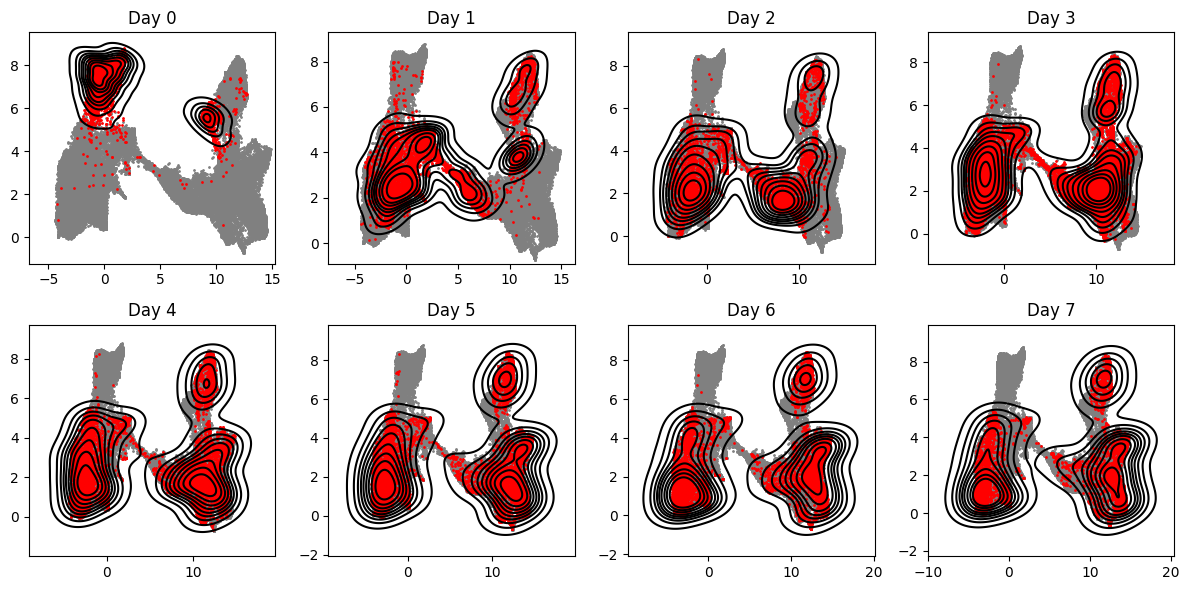

In [10]:
days = sorted(metadata['CellWeek'].unique())

fig, ax = plt.subplots(2, 4, figsize = (12, 6))
axs = ax.flatten()

for ai, d in enumerate(days): 
    ax = axs[ai]
    ax.scatter(xu[metadata['CellWeek'] != d,0], xu[metadata['CellWeek'] != d,1], s = 1, 
        color = 'gray')
    ax.scatter(xu[metadata['CellWeek'] == d,0], xu[metadata['CellWeek'] == d,1], s = 1, 
        color = 'red')
    sns.kdeplot(x=xu[metadata['CellWeek'] == d,0], y=xu[metadata['CellWeek'] == d,1], color = 'k',ax=ax)
    ax.set_title('Day {}'.format(d))
    
plt.tight_layout() 

<AxesSubplot:>

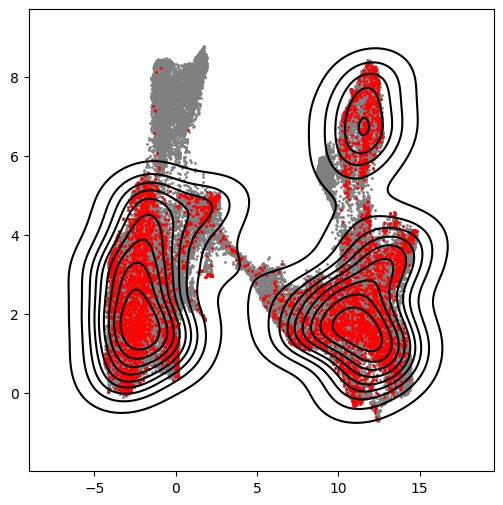

In [11]:
T=4
fig, ax = plt.subplots(figsize = (6, 6))
ax.scatter(xu[:,0], xu[:,1], s = 1, color = 'gray')

px = y == T
ax.scatter(xu[px,0], xu[px, 1], color = 'red', s = 1)
sns.kdeplot(x=xu[px,0], y=xu[px, 1], color = 'k')

In [12]:
from joblib import dump
dump(um, 'alltime/um_transformer.joblib')

['alltime/um_transformer.joblib']